In [2]:
# 1 September - Extract fragment intensity list and stack as grayscale image for LSEPAELTDAVK. Each fragment ion represents one row. 
# The X axis on the grayscale map represents the Elution Time as specified in the .chrom file. Extract the list of (Intensity,RT) pairs and for one peptide bin the intensity values, scale and plot as grayscale
import pymzml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle
import random
import re
import scipy.misc
import itertools
import time
%matplotlib inline
import PIL
from PIL import Image

In [3]:
pyprophet_dir = "D:\ETH\RA\Aqua_Peptide_Extraction\mzxml_decoy\multi_file_data"
chrom_mzml_dir = "D:\ETH\RA\Aqua_Peptide_Extraction\mzxml_decoy\multi_file_data"

def asinhnorm_mat(data_arr):
    final_newnorm_full = []
    for i in range(data_arr.shape[0]):
        temp = []
        for j in range(data_arr.shape[1]):
            temp.append(np.arcsinh(10.0*data_arr[i][j])/3.0)
        final_newnorm_full.append(temp)
    final_newnorm_array_full = np.asarray(final_newnorm_full)
    final_newnorm_array_full = final_newnorm_array_full/final_newnorm_array_full.max()
    return final_newnorm_array_full

def asinhnorm_list(data_list):
    list_t = (np.arcsinh(10.0*data_list)/3.0)
    return list_t/max(list_t)

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [4]:
# Iterate over each file, in each file iterate over each peptide, in each peptide iterate over each fragment ion
# For each peptide there are 6 fragments(?), the length of (intensity,rt) pairs for each fragment of a peptide is the same
# For each peptide save the stacked/reshaped fragment grayscale map for display in a list and also flatten this as a feature vector and append to data
# Final grayscale matrix list should contain all peptides, wherein each row is a matrix of normalized intensity values that can be plotted directly
# Final data matrix should contain all peptides, wherein each row is a flat list of feature vectors, all normalized values.

gcount = 1
data = []
labels = []
grayscale_reshaped_mat_list = []
for result_filename in sorted(os.listdir(pyprophet_dir)):
    if result_filename.endswith("scored.txt"):
        core_file_name = find_between(result_filename,"TSV_",".mzXML")
        chrom_file_name = "OUT_CHROM_" + core_file_name + ".mzXML.gz.chrom.mzML"
        chrom_file_path = os.path.join(chrom_mzml_dir,"{}".format(chrom_file_name))
        df = pd.read_csv(os.path.join(pyprophet_dir,result_filename),sep='\t', header=(0))
        # Iterate over all selected peak groups
        for i in range(len(df['aggr_Fragment_Annotation'])):
            # Extract grayscale images only for LSEPAELTDAVK - TODO for all peptides
            if(df['Sequence'][i] == "LSEPAELTDAVK" ):
                fragment_ions = df['aggr_Fragment_Annotation'][i]
                # Get list of fragment ions for THAT peptide
                fragment_ions_list = fragment_ions.split(";")
                print("\n{} FRAGMENT IONS FOR PEPTIDE {} = {} ** GCOUNT = {}".format(len(fragment_ions_list), df['peptide_group_label'][i],fragment_ions_list,gcount))
                gcount = gcount + 1
                start_time = round(df['leftWidth'][i],2)
                stop_time = round(df['rightWidth'][i],2)
                print("Start(leftWidth) time = {} and Stop(rightWidth) time = {}".format(start_time,stop_time))
                fragment_intensity_list = []
                fragment_shape_x = len(fragment_ions_list)
                fragment_shape_y = 0
                labels.append(df['peak_group_rank'][i])
                data_temp = []
                # TODO - Optimize this, open chrom file just once and save relevant peak values!
                # Iterate over each fragment ion
                for j in range(len(fragment_ions_list)):
                    # The chrom.mzML file has to be opened on each iteration, otherwise leads to the information being discarded
                    run = pymzml.run.Reader(chrom_file_path)
                    for spec in run:               
                        # Find and plot the curve for that fragment ion from the chrom.mzML file, after decoding the binary array
                        if spec['id'] == fragment_ions_list[j]:
                            tmp_peak = spec.peaks
                            #print(tmp_peak)
                            x = [float(z[0]) for z in tmp_peak]
                            y = [float(z[1]) for z in tmp_peak]
                            sub_x = x[x.index(start_time):x.index(stop_time)]
                            sub_y = y[x.index(start_time):x.index(stop_time)]
                            if(len(sub_x) == len(sub_y)):
                                fragment_shape_y = len(sub_x)
                            else:
                                print("####Length of X NOT EQUAL to Length of Y")
                                raise
                            fragment_intensity_list.append(sub_y)
                            data_temp.append(sub_y)
                            #print("Found fragment ion at j = {} Length of time array = {} Length of Intensity Array = {}".format(j, len(x),len(y)))
                            #print("Length of sub_x = {}\n sub_x = {}\nLength of sub_y = {}\n sub_y = {}".format(len(sub_x),sub_x,len(sub_y),sub_y))
                data.append([item for sublist in data_temp for item in sublist])
                plot_fragment_ravel = np.asarray(fragment_intensity_list).ravel()
                plot_fragment_mat = plot_fragment_ravel.reshape(fragment_shape_x, fragment_shape_y)
                grayscale_reshaped_mat_list.append(plot_fragment_mat)
                #plt.figure()
                #plt.subplot(121)
                #plt.imshow(asinhnorm_mat(plot_fragment_mat),cmap="gray")
                #plt.savefig(r"C:\Users\Prashanth\$Development\Peptide_Extraction\Fixed_GrayScale\{}_Rank_{}.png".format(df['peptide_group_label'][i],df['peak_group_rank'][i]),dpi=800)


6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 1
Start(leftWidth) time = 1674.08 and Stop(rightWidth) time = 1703.83

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 2
Start(leftWidth) time = 1723.66 and Stop(rightWidth) time = 1756.71

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 3
Start(leftWidth) time = 1455.93 and Stop(rightWidth) time = 1488.98

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAEL


6 FRAGMENT IONS FOR PEPTIDE 90000068_LSEPAELTDAVK(UniMod:259)_2 = ['90000958_LSEPAELTDAVK(UniMod:259)_2', '90000950_LSEPAELTDAVK(UniMod:259)_2', '90000959_LSEPAELTDAVK(UniMod:259)_2', '90000955_LSEPAELTDAVK(UniMod:259)_2', '90000952_LSEPAELTDAVK(UniMod:259)_2', '90000957_LSEPAELTDAVK(UniMod:259)_2'] ** GCOUNT = 26
Start(leftWidth) time = 1829.46 and Stop(rightWidth) time = 1852.59

6 FRAGMENT IONS FOR PEPTIDE 10000069_LSEPAELTDAVK_3 = ['10000967_LSEPAELTDAVK_3', '10000972_LSEPAELTDAVK_3', '10000968_LSEPAELTDAVK_3', '10000974_LSEPAELTDAVK_3', '10000965_LSEPAELTDAVK_3', '10000976_LSEPAELTDAVK_3'] ** GCOUNT = 27
Start(leftWidth) time = 1907.48 and Stop(rightWidth) time = 1924.01

6 FRAGMENT IONS FOR PEPTIDE 10000069_LSEPAELTDAVK_3 = ['10000967_LSEPAELTDAVK_3', '10000972_LSEPAELTDAVK_3', '10000968_LSEPAELTDAVK_3', '10000974_LSEPAELTDAVK_3', '10000965_LSEPAELTDAVK_3', '10000976_LSEPAELTDAVK_3'] ** GCOUNT = 28
Start(leftWidth) time = 1540.6 and Stop(rightWidth) time = 1567.04

6 FRAGMENT IO


6 FRAGMENT IONS FOR PEPTIDE 10000069_LSEPAELTDAVK_3 = ['10000967_LSEPAELTDAVK_3', '10000972_LSEPAELTDAVK_3', '10000968_LSEPAELTDAVK_3', '10000974_LSEPAELTDAVK_3', '10000965_LSEPAELTDAVK_3', '10000976_LSEPAELTDAVK_3'] ** GCOUNT = 51
Start(leftWidth) time = 1758.74 and Stop(rightWidth) time = 1791.8

6 FRAGMENT IONS FOR PEPTIDE 90000069_LSEPAELTDAVK(UniMod:259)_3 = ['90000967_LSEPAELTDAVK(UniMod:259)_3', '90000972_LSEPAELTDAVK(UniMod:259)_3', '90000968_LSEPAELTDAVK(UniMod:259)_3', '90000974_LSEPAELTDAVK(UniMod:259)_3', '90000965_LSEPAELTDAVK(UniMod:259)_3', '90000976_LSEPAELTDAVK(UniMod:259)_3'] ** GCOUNT = 52
Start(leftWidth) time = 1646.37 and Stop(rightWidth) time = 1676.11

6 FRAGMENT IONS FOR PEPTIDE 90000069_LSEPAELTDAVK(UniMod:259)_3 = ['90000967_LSEPAELTDAVK(UniMod:259)_3', '90000972_LSEPAELTDAVK(UniMod:259)_3', '90000968_LSEPAELTDAVK(UniMod:259)_3', '90000974_LSEPAELTDAVK(UniMod:259)_3', '90000965_LSEPAELTDAVK(UniMod:259)_3', '90000976_LSEPAELTDAVK(UniMod:259)_3'] ** GCOUNT = 5


6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 75
Start(leftWidth) time = 1452.63 and Stop(rightWidth) time = 1479.07

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 76
Start(leftWidth) time = 1607.98 and Stop(rightWidth) time = 1647.64

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 77
Start(leftWidth) time = 1849.26 and Stop(rightWidth) time = 1879.01

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEP


6 FRAGMENT IONS FOR PEPTIDE 90000068_LSEPAELTDAVK(UniMod:259)_2 = ['90000958_LSEPAELTDAVK(UniMod:259)_2', '90000950_LSEPAELTDAVK(UniMod:259)_2', '90000959_LSEPAELTDAVK(UniMod:259)_2', '90000955_LSEPAELTDAVK(UniMod:259)_2', '90000952_LSEPAELTDAVK(UniMod:259)_2', '90000957_LSEPAELTDAVK(UniMod:259)_2'] ** GCOUNT = 100
Start(leftWidth) time = 1793.1 and Stop(rightWidth) time = 1822.85

6 FRAGMENT IONS FOR PEPTIDE 90000068_LSEPAELTDAVK(UniMod:259)_2 = ['90000958_LSEPAELTDAVK(UniMod:259)_2', '90000950_LSEPAELTDAVK(UniMod:259)_2', '90000959_LSEPAELTDAVK(UniMod:259)_2', '90000955_LSEPAELTDAVK(UniMod:259)_2', '90000952_LSEPAELTDAVK(UniMod:259)_2', '90000957_LSEPAELTDAVK(UniMod:259)_2'] ** GCOUNT = 101
Start(leftWidth) time = 1495.63 and Stop(rightWidth) time = 1515.46

6 FRAGMENT IONS FOR PEPTIDE 90000068_LSEPAELTDAVK(UniMod:259)_2 = ['90000958_LSEPAELTDAVK(UniMod:259)_2', '90000950_LSEPAELTDAVK(UniMod:259)_2', '90000959_LSEPAELTDAVK(UniMod:259)_2', '90000955_LSEPAELTDAVK(UniMod:259)_2', '9000


6 FRAGMENT IONS FOR PEPTIDE 10000069_LSEPAELTDAVK_3 = ['10000967_LSEPAELTDAVK_3', '10000972_LSEPAELTDAVK_3', '10000968_LSEPAELTDAVK_3', '10000974_LSEPAELTDAVK_3', '10000965_LSEPAELTDAVK_3', '10000976_LSEPAELTDAVK_3'] ** GCOUNT = 124
Start(leftWidth) time = 1682.72 and Stop(rightWidth) time = 1709.16

6 FRAGMENT IONS FOR PEPTIDE 10000069_LSEPAELTDAVK_3 = ['10000967_LSEPAELTDAVK_3', '10000972_LSEPAELTDAVK_3', '10000968_LSEPAELTDAVK_3', '10000974_LSEPAELTDAVK_3', '10000965_LSEPAELTDAVK_3', '10000976_LSEPAELTDAVK_3'] ** GCOUNT = 125
Start(leftWidth) time = 1795.1 and Stop(rightWidth) time = 1828.15

6 FRAGMENT IONS FOR PEPTIDE 10000069_LSEPAELTDAVK_3 = ['10000967_LSEPAELTDAVK_3', '10000972_LSEPAELTDAVK_3', '10000968_LSEPAELTDAVK_3', '10000974_LSEPAELTDAVK_3', '10000965_LSEPAELTDAVK_3', '10000976_LSEPAELTDAVK_3'] ** GCOUNT = 126
Start(leftWidth) time = 1603.4 and Stop(rightWidth) time = 1643.06

6 FRAGMENT IONS FOR PEPTIDE 10000069_LSEPAELTDAVK_3 = ['10000967_LSEPAELTDAVK_3', '10000972_LSE


6 FRAGMENT IONS FOR PEPTIDE 90000069_LSEPAELTDAVK(UniMod:259)_3 = ['90000967_LSEPAELTDAVK(UniMod:259)_3', '90000972_LSEPAELTDAVK(UniMod:259)_3', '90000968_LSEPAELTDAVK(UniMod:259)_3', '90000974_LSEPAELTDAVK(UniMod:259)_3', '90000965_LSEPAELTDAVK(UniMod:259)_3', '90000976_LSEPAELTDAVK(UniMod:259)_3'] ** GCOUNT = 149
Start(leftWidth) time = 1682.72 and Stop(rightWidth) time = 1709.16

6 FRAGMENT IONS FOR PEPTIDE 90000069_LSEPAELTDAVK(UniMod:259)_3 = ['90000967_LSEPAELTDAVK(UniMod:259)_3', '90000972_LSEPAELTDAVK(UniMod:259)_3', '90000968_LSEPAELTDAVK(UniMod:259)_3', '90000974_LSEPAELTDAVK(UniMod:259)_3', '90000965_LSEPAELTDAVK(UniMod:259)_3', '90000976_LSEPAELTDAVK(UniMod:259)_3'] ** GCOUNT = 150
Start(leftWidth) time = 1398.47 and Stop(rightWidth) time = 1428.22

6 FRAGMENT IONS FOR PEPTIDE 90000069_LSEPAELTDAVK(UniMod:259)_3 = ['90000967_LSEPAELTDAVK(UniMod:259)_3', '90000972_LSEPAELTDAVK(UniMod:259)_3', '90000968_LSEPAELTDAVK(UniMod:259)_3', '90000974_LSEPAELTDAVK(UniMod:259)_3', '900


6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 173
Start(leftWidth) time = 1717.05 and Stop(rightWidth) time = 1750.1

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 174
Start(leftWidth) time = 1449.32 and Stop(rightWidth) time = 1475.76

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LSEPAELTDAVK_2', '10000959_LSEPAELTDAVK_2', '10000955_LSEPAELTDAVK_2', '10000952_LSEPAELTDAVK_2', '10000957_LSEPAELTDAVK_2'] ** GCOUNT = 175
Start(leftWidth) time = 1842.65 and Stop(rightWidth) time = 1865.78

6 FRAGMENT IONS FOR PEPTIDE 10000068_LSEPAELTDAVK_2 = ['10000958_LSEPAELTDAVK_2', '10000950_LS

In [5]:
print("Completed extracting data and grayscale maps!")

Completed extracting data and grayscale maps!


In [6]:
# Verify that no normalization has been done so far on 'data' and 'grayscale_reshaped_mat_list'

print(data)
print(grayscale_reshaped_mat_list)

[[84.0, 420.0, 1343.0, 2677.0, 4290.0, 3349.0, 1797.0, 1124.0, 210.0, 36.0, 294.0, 1164.0, 1975.0, 3598.0, 2719.0, 1510.0, 504.0, 294.0, 0.0, 0.0, 42.0, 41.0, 123.0, 82.0, 42.0, 0.0, 0.0, 84.0, 0.0, 462.0, 1249.0, 1427.0, 1361.0, 418.0, 333.0, 208.0, 36.0, 168.0, 656.0, 1027.0, 2203.0, 1535.0, 584.0, 252.0, 84.0, 42.0, 36.0, 504.0, 1052.0, 1764.0, 1072.0, 671.0, 168.0, 42.0], [84.0, 168.0, 922.0, 2680.0, 3475.0, 4532.0, 3518.0, 1744.0, 796.0, 252.0, 42.0, 294.0, 714.0, 1748.0, 3026.0, 3967.0, 3159.0, 1521.0, 504.0, 168.0, 0.0, 0.0, 0.0, 0.0, 41.0, 82.0, 41.0, 0.0, 0.0, 0.0, 0.0, 0.0, 252.0, 906.0, 1504.0, 1334.0, 1582.0, 753.0, 84.0, 126.0, 0.0, 42.0, 252.0, 840.0, 1629.0, 1151.0, 1230.0, 546.0, 420.0, 0.0, 0.0, 168.0, 168.0, 714.0, 1447.0, 1369.0, 1383.0, 546.0, 252.0, 84.0], [0.0, 84.0, 126.0, 1014.0, 1089.0, 1176.0, 378.0, 126.0, 0.0, 42.0, 0.0, 0.0, 84.0, 126.0, 168.0, 210.0, 42.0, 36.0, 0.0, 168.0, 0.0, 42.0, 0.0, 721.0, 377.0, 460.0, 168.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [7]:
with open("data.pickle","wb") as fp:
    pickle.dump(data,fp)

In [16]:
with open("labels.pickle","wb") as fp:
    pickle.dump(labels,fp)

In [ ]:
with open("data.pickle","rb") as fp:
    data = pickle.load(fp)

In [ ]:
with open("labels.pickle","rb") as fp:
    labels = pickle.load(fp)

In [8]:
# Convert extracted feature vectors above into a numpy array to pad. Ensure that the length of each element in the padded array
# is equal to the length of the largest feature vector in 'data'
data_arr = np.asarray(data)
length_list = []
for i in range(len(data_arr)):
    length_list.append(len(data_arr[i]))
print("Maximum length feature vector = {}".format(max(length_list)))

Maximum length feature vector = 78


In [9]:
# Padd our data array to normalize length
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out

data_filled = numpy_fillna(data_arr)

# Now normalize the entire data matrix as max() works only on shaped matrices
data_filled = asinhnorm_mat(data_filled)

In [10]:
# Ensure that shape[1] matches the maximum length we got above
data_filled.shape

(191, 78)

In [11]:
# Ensure len(labels) = data_filled.shape[0]
print(labels)
len(labels)

[2, 1, 3, 5, 4, 1, 4, 3, 2, 5, 1, 2, 3, 4, 5, 1, 2, 1, 5, 3, 4, 1, 3, 2, 4, 5, 2, 5, 1, 4, 3, 4, 3, 1, 2, 5, 1, 4, 2, 5, 3, 1, 2, 3, 4, 5, 1, 4, 2, 3, 5, 2, 1, 1, 3, 2, 4, 5, 1, 2, 3, 5, 4, 3, 1, 2, 5, 4, 1, 3, 4, 2, 5, 1, 2, 4, 3, 5, 1, 2, 4, 5, 3, 1, 2, 4, 3, 5, 4, 5, 1, 3, 2, 1, 2, 5, 3, 4, 1, 5, 4, 2, 3, 5, 2, 1, 3, 4, 1, 3, 2, 5, 4, 1, 2, 4, 3, 5, 1, 3, 5, 2, 4, 1, 3, 2, 4, 5, 4, 1, 2, 3, 5, 2, 1, 4, 5, 3, 1, 3, 2, 4, 5, 2, 4, 3, 5, 1, 3, 1, 2, 5, 4, 2, 1, 3, 4, 5, 1, 5, 2, 3, 4, 1, 5, 4, 2, 3, 2, 1, 3, 1, 2, 3, 4, 5, 1, 3, 4, 5, 2, 2, 5, 1, 4, 3, 1, 3, 4, 5, 2]


191

In [12]:
# Normalization of grayscale matrix
# Done manually as this matrix is of uneven shape

print("Unnormalized GrayScale Matrix = {}\n\n".format(grayscale_reshaped_mat_list))
max_element = 0.0
for i in range(len(grayscale_reshaped_mat_list)):
    for j in range(len(grayscale_reshaped_mat_list[i])):
        for k in range(len(grayscale_reshaped_mat_list[i][j])):
            grayscale_reshaped_mat_list[i][j][k] = np.arcsinh(10.0 * grayscale_reshaped_mat_list[i][j][k])/3.0
            if(grayscale_reshaped_mat_list[i][j][k] > max_element):
                max_element = grayscale_reshaped_mat_list[i][j][k]
check_max = 0.0
for i in range(len(grayscale_reshaped_mat_list)):
    for j in range(len(grayscale_reshaped_mat_list[i])):
        for k in range(len(grayscale_reshaped_mat_list[i][j])):
            grayscale_reshaped_mat_list[i][j][k] = grayscale_reshaped_mat_list[i][j][k]/max_element
            if(grayscale_reshaped_mat_list[i][j][k] > check_max):
                check_max = grayscale_reshaped_mat_list[i][j][k]      
                
print("\nMax asinh normalized value = {}".format(max_element))
print("\n\nNormalized GrayScale Matrix = {}\n\n\nMaximum normalized value (Should be 1.0) = {}".format(grayscale_reshaped_mat_list, check_max))

Unnormalized GrayScale Matrix = [array([[   84.,   420.,  1343.,  2677.,  4290.,  3349.,  1797.,  1124.,
          210.],
       [   36.,   294.,  1164.,  1975.,  3598.,  2719.,  1510.,   504.,
          294.],
       [    0.,     0.,    42.,    41.,   123.,    82.,    42.,     0.,
            0.],
       [   84.,     0.,   462.,  1249.,  1427.,  1361.,   418.,   333.,
          208.],
       [   36.,   168.,   656.,  1027.,  2203.,  1535.,   584.,   252.,
           84.],
       [   42.,    36.,   504.,  1052.,  1764.,  1072.,   671.,   168.,
           42.]]), array([[   84.,   168.,   922.,  2680.,  3475.,  4532.,  3518.,  1744.,
          796.,   252.],
       [   42.,   294.,   714.,  1748.,  3026.,  3967.,  3159.,  1521.,
          504.,   168.],
       [    0.,     0.,     0.,     0.,    41.,    82.,    41.,     0.,
            0.,     0.],
       [    0.,     0.,   252.,   906.,  1504.,  1334.,  1582.,   753.,
           84.,   126.],
       [    0.,    42.,   252.,   840.,  16

In [181]:
# Verification that our grayscale_reshaped_mat_list is plottable after normalization
for i in range(10):
    plt.figure()
    plt.subplot(121)
    plt.imshow(grayscale_reshaped_mat_list[i],cmap="gray")

Computing t-SNE embedding


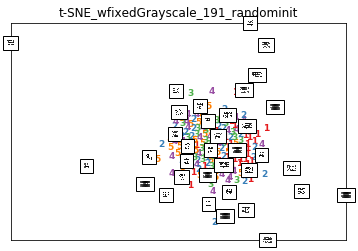

In [13]:
# t-SNE Embedding of Feature Vectors 

from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)


X = data_filled
y = np.asarray(labels)
n_samples, n_features = X.shape
n_neighbors = 30


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            #temp_X = [z for z in final_newnorm_array[i]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.asarray(grayscale_reshaped_mat_list[i]), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.savefig("{}.png".format(title),dpi = 1000)


#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='random', random_state=0)
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE_wfixedGrayscale_191_randominit")

plt.show()

In [17]:
with open("x_tsne_191.pickle","wb") as fp:
    pickle.dump(X_tsne,fp)

In [ ]:
with open("x_tsne_191.pickle","rb") as fp:
    X_tsne = pickle.load(fp)

In [14]:
len(X_tsne)

191

In [15]:
# KNN WITHOUT Leave-One Out ('woloo')

from sklearn.neighbors import KNeighborsClassifier

neighbours_woloo_1 = KNeighborsClassifier(n_neighbors=1)
neighbours_woloo_1.fit(X_tsne, labels) 
neighbours_woloo_3 = KNeighborsClassifier(n_neighbors=3)
neighbours_woloo_3.fit(X_tsne, labels) 
neighbours_woloo_5 = KNeighborsClassifier(n_neighbors=5)
neighbours_woloo_5.fit(X_tsne, labels) 
neighbours_woloo_7 = KNeighborsClassifier(n_neighbors=7)
neighbours_woloo_7.fit(X_tsne, labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [57]:
# Create table with KNN representation, OS rank etc..

start_time = time.time()

gcount = 0
data_df = pd.DataFrame()
# Filepath gets truncated
pd.set_option('display.max_colwidth', -1)
for result_filename in sorted(os.listdir(pyprophet_dir)):
    if result_filename.endswith("scored.txt"):
        core_file_name = find_between(result_filename,"TSV_",".mzXML")
        chrom_file_name = "OUT_CHROM_" + core_file_name + ".mzXML.gz.chrom.mzML"
        chrom_file_path = os.path.join(chrom_mzml_dir,"{}".format(chrom_file_name))
        df = pd.read_csv(os.path.join(pyprophet_dir,result_filename),sep='\t', header=(0))
        peak_group_folder = "D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output"
        
        # Iterate over all selected peak groups
        
        for i in range(len(df['aggr_Fragment_Annotation'])):
            
            # Extract grayscale images only for LSEPAELTDAVK - TODO for all peptides
            
            if(df['Sequence'][i] == "LSEPAELTDAVK" ):
                
                fragment_ions = df['aggr_Fragment_Annotation'][i]
                
                re_sub_exp = re.sub('[^\w\-_\. ]', '_', df['peptide_group_label'][i])
                
                if df['peak_group_rank'][i] == 1:
                    final_sub_folder = 1
                else:
                    final_sub_folder = 0
                
                peakgroup_filename = "{}_rank_{}.png".format(df['Sequence'][i],df['peak_group_rank'][i])
                
                peakgroup_image_path = r"D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\{}\{}\{}\{}".format(core_file_name, re_sub_exp, final_sub_folder,peakgroup_filename)
                
                grayscale_image_file_name = "{}_Rank_{}.png".format(re_sub_exp, df['peak_group_rank'][i])
                
                grayscale_image_path = r"D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\{}".format(core_file_name)
                
                if not os.path.exists(grayscale_image_path):
                    os.makedirs(grayscale_image_path)
                
                grayscale_image_path = os.path.join(grayscale_image_path, grayscale_image_file_name)
                
                plt.figure()
                
                plt.axis('off')
                
                plt.imshow(grayscale_reshaped_mat_list[gcount],cmap=plt.cm.gray_r)

                plt.savefig(grayscale_image_path, bbox_inches='tight')
                
                plt.clf()
                
                plt.close('all')
                    
                im = PIL.Image.open(grayscale_image_path)
                
                imResize = im.resize((800,600), PIL.Image.ANTIALIAS)
                
                imResize.save("{}".format(grayscale_image_path),quality=100)
                
                temp_X_tsne = np.delete(X_tsne, gcount, axis=0)
                temp_labels = labels[:gcount] + labels[gcount+1:]
                neighbours_loo_1 = KNeighborsClassifier(n_neighbors=1)
                neighbours_loo_1.fit(temp_X_tsne, temp_labels) 
                neighbours_loo_3 = KNeighborsClassifier(n_neighbors=3)
                neighbours_loo_3.fit(temp_X_tsne, temp_labels) 
                neighbours_loo_5 = KNeighborsClassifier(n_neighbors=5)
                neighbours_loo_5.fit(temp_X_tsne, temp_labels) 
                neighbours_loo_7 = KNeighborsClassifier(n_neighbors=7)
                neighbours_loo_7.fit(temp_X_tsne, temp_labels) 


                # Use file:/// for windows and file:\\ for linux 
                temp_row = pd.DataFrame(np.array([[core_file_name, df['RT'][i], df['peptide_group_label'][i], '<img src="{}"/>'.format(grayscale_image_path), '<img src="{}"/>'.format(peakgroup_image_path), df['peak_group_rank'][i], str(neighbours_woloo_1.predict(X_tsne[gcount])), str(neighbours_woloo_3.predict(X_tsne[gcount])), str(neighbours_woloo_5.predict(X_tsne[gcount])), str(neighbours_woloo_7.predict(X_tsne[gcount])),  str(neighbours_loo_1.predict(X_tsne[gcount])), str(neighbours_loo_3.predict(X_tsne[gcount])), str(neighbours_loo_5.predict(X_tsne[gcount])), str(neighbours_loo_7.predict(X_tsne[gcount]))]]), columns = ["File Name", "RT", "ID", "Grayscale Map", "Peakgroup", "OpenSWATH Rank", "KNN_1 w/o LOO", "KNN_3 w/o LOO", "KNN_5 w/o LOO", "KNN_7 w/o LOO", "KNN_1 LOO", "KNN_3 LOO", "KNN_5 LOO", "KNN_7 LOO"])
                
                data_df = data_df.append(temp_row)
                
                gcount = gcount + 1
                
                print("Count = {}".format(gcount))
                
data_df = data_df.sort_values(by=['File Name', 'ID', 'OpenSWATH Rank'])

elapsed_time = time.time() - start_time

print("Time taken = {}s".format(elapsed_time))

Count = 1
Count = 2
Count = 3
Count = 4
Count = 5
Count = 6
Count = 7
Count = 8
Count = 9
Count = 10
Count = 11
Count = 12
Count = 13
Count = 14
Count = 15
Count = 16
Count = 17
Count = 18
Count = 19
Count = 20
Count = 21
Count = 22
Count = 23
Count = 24
Count = 25
Count = 26
Count = 27
Count = 28
Count = 29
Count = 30
Count = 31
Count = 32
Count = 33
Count = 34
Count = 35
Count = 36
Count = 37
Count = 38
Count = 39
Count = 40
Count = 41
Count = 42
Count = 43
Count = 44
Count = 45
Count = 46
Count = 47
Count = 48
Count = 49
Count = 50
Count = 51
Count = 52
Count = 53
Count = 54
Count = 55
Count = 56
Count = 57
Count = 58
Count = 59
Count = 60
Count = 61
Count = 62
Count = 63
Count = 64
Count = 65
Count = 66
Count = 67
Count = 68
Count = 69
Count = 70
Count = 71
Count = 72
Count = 73
Count = 74
Count = 75
Count = 76
Count = 77
Count = 78
Count = 79
Count = 80
Count = 81
Count = 82
Count = 83
Count = 84
Count = 85
Count = 86
Count = 87
Count = 88
Count = 89
Count = 90
Count = 91
Count = 

In [58]:
data_df

,File Name,RT,ID,Grayscale Map,Peakgroup,OpenSWATH Rank,KNN_1 w/o LOO,KNN_3 w/o LOO,KNN_5 w/o LOO,KNN_7 w/o LOO,KNN_1 LOO,KNN_3 LOO,KNN_5 LOO,KNN_7 LOO
0,guot__PC4_170203_CPP10_sw,1739.75744996,10000068_LSEPAELTDAVK_2,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2_Rank_1.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2\1\LSEPAELTDAVK_rank_1.png""/>",1,[1],[1],[1],[1],[1],[1],[1],[1]
0,guot__PC4_170203_CPP10_sw,1688.15524261,10000068_LSEPAELTDAVK_2,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2_Rank_2.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2\0\LSEPAELTDAVK_rank_2.png""/>",2,[2],[2],[2],[2],[2],[2],[5],[5]
0,guot__PC4_170203_CPP10_sw,1469.77613934,10000068_LSEPAELTDAVK_2,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2_Rank_3.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2\0\LSEPAELTDAVK_rank_3.png""/>",3,[3],[1],[2],[2],[1],[1],[2],[1]
0,guot__PC4_170203_CPP10_sw,1777.4559205,10000068_LSEPAELTDAVK_2,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2_Rank_4.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2\0\LSEPAELTDAVK_rank_4.png""/>",4,[4],[3],[3],[3],[3],[3],[3],[3]
0,guot__PC4_170203_CPP10_sw,1896.25722924,10000068_LSEPAELTDAVK_2,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2_Rank_5.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000068_LSEPAELTDAVK_2\0\LSEPAELTDAVK_rank_5.png""/>",5,[5],[5],[5],[5],[5],[5],[1],[1]
0,guot__PC4_170203_CPP10_sw,1570.05732943,10000069_LSEPAELTDAVK_3,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3_Rank_1.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3\1\LSEPAELTDAVK_rank_1.png""/>",1,[1],[2],[2],[2],[2],[2],[2],[3]
0,guot__PC4_170203_CPP10_sw,1523.29438745,10000069_LSEPAELTDAVK_3,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3_Rank_2.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3\0\LSEPAELTDAVK_rank_2.png""/>",2,[2],[2],[2],[4],[3],[3],[3],[4]
0,guot__PC4_170203_CPP10_sw,2104.83073212,10000069_LSEPAELTDAVK_3,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3_Rank_3.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3\0\LSEPAELTDAVK_rank_3.png""/>",3,[3],[3],[3],[3],[3],[3],[3],[4]
0,guot__PC4_170203_CPP10_sw,1891.44438152,10000069_LSEPAELTDAVK_3,"<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3_Rank_4.png""/>","<img src=""D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Color_LinearScale_Output\guot__PC4_170203_CPP10_sw\10000069_LSEPAELTDAVK_3\0\LSEPAELTDAVK_rank_4.png""/>",4,[4],[2],[2],[2],[2],[2],[2],[2]
0,guot__PC4_170

In [59]:
data_df.to_html("LSEPAELTDAVK_191_resized.html", escape = False)

In [ ]:
plt.hist(data_filled)
plt.savefig("histogram1.png")

In [36]:
from PIL import Image
import os, sys

dirs = os.listdir(path)

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            print(path+item)
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((1024,768), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

resize()

In [44]:
path = "D:\ETH\RA\Aqua_Peptide_Extraction\colored_ions_extract\Grayscale_map_fixed\guot__PC4_170203_CPP4_sw"

dirs = os.listdir(path)
count = 0
for item in dirs:
    im = PIL.Image.open(os.path.join(path,item))
    imResize = im.resize((1024,768), PIL.Image.ANTIALIAS)
    imResize.save("{}".format(os.path.join(path,item)),quality=100)
    count = count +1